<a href="https://colab.research.google.com/github/xy2119/Data_Mining/blob/main/Recommender_System/GAE_VGAE_user_item.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAE & VGAE Pretraining on Heterogeneous User-Item Information

In [ ]:
!pip install --upgrade gensim
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
import pandas as pd
import numpy as np

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import random
random.seed(2022)
np.random.seed(2022)
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving rating.csv to rating.csv
Saving trust.csv to trust.csv


In [ ]:
import io
rating=pd.read_csv(io.BytesIO(uploaded['rating.csv']),index_col=0)
trust=pd.read_csv(io.BytesIO(uploaded['trust.csv']),index_col=0)
trust

,user_id(trustor),user_id(trustee),trust_value
0,2,966,1
1,2,104,1
2,5,1509,1
3,6,1192,1
4,7,1510,1
...,...,...,...
1848,1507,806,1
1849,1507,361,1
1850,1508,1187,1
1851,1508,509,1


In [ ]:
from sklearn import preprocessing as pp
le_user = pp.LabelEncoder()
le_user = le_user.fit(np.concatenate([trust['user_id(trustor)'], trust['user_id(trustee)'],rating['user_id']]))

trust['trustor_id_idx'] = le_user.transform(trust['user_id(trustor)'].values)
trust['trustee_id_idx'] = le_user.transform(trust['user_id(trustee)'].values)
rating['user_id_idx'] = le_user.fit_transform(rating['user_id'].values)

le_item = pp.LabelEncoder()
rating['item_id_idx'] = le_item.fit_transform(rating['item_id'].values)

rating

,user_id,item_id,rating_value,user_id_idx,item_id_idx
0,1050,215,3.0,1049,214
1,1050,250,2.0,1049,249
2,1050,251,2.5,1049,250
3,1051,213,3.0,1050,212
4,1051,241,3.5,1050,240
...,...,...,...,...,...
35492,1050,12,3.5,1049,11
35493,1050,249,2.0,1049,248
35494,1050,17,4.0,1049,16
35495,1050,220,2.5,1049,219


In [ ]:
n_trustor = trust['trustor_id_idx'].nunique()
# ([trust['user_id(trustor)']+ trust['user_id(trustee)']+rating['user_id']]).nunique()
# rating['user_id_idx'].nunique()
n_trustee = trust['trustee_id_idx'].nunique()

trustor_t = torch.LongTensor(trust.trustor_id_idx)
trustee_t = torch.LongTensor(trust.trustee_id_idx) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
edge_index = torch.stack((
  torch.cat([trustor_t, trustee_t]),
  torch.cat([trustee_t, trustor_t]) ))

edge_index

In [ ]:
import torch
from torch_geometric.data import Dataset,InMemoryDataset, download_url
from torch_geometric.data.collate import collate

class EdgePerturbation():
    """
    Edge perturbation on the given graph or batched graphs. Class objects callable via 
    method :meth:`views_fn`.
    
    Args:
        add (bool, optional): Set :obj:`True` if randomly add edges in a given graph.
            (default: :obj:`True`)
        drop (bool, optional): Set :obj:`True` if randomly drop edges in a given graph.
            (default: :obj:`False`)
        ratio (float, optional): Percentage of edges to add or drop. (default: :obj:`0.1`)
    """

    def __init__(self, add=False, drop=True, ratio=0.1):
        self.add = add
        self.drop = drop
        self.ratio = ratio
        
    def do_trans(self, data):
        node_num, _ = data.x.size()
        _, edge_num = data.edge_index.size()
        perturb_num = int(edge_num * self.ratio)

        edge_index = data.edge_index.detach().clone()
        idx_remain = edge_index
        idx_add = torch.tensor([]).reshape(2, -1).long()

        if self.drop:
            idx_remain = edge_index[:, np.random.choice(edge_num, edge_num-perturb_num, replace=False)]

        if self.add:
            idx_add = torch.randint(node_num, (2, perturb_num))

        new_edge_index = torch.cat((idx_remain, idx_add), dim=1)
        new_edge_index = torch.unique(new_edge_index, dim=1)

        return Data(x=data.x, edge_index=new_edge_index,y=data.y)

#训练数据集
class MyData(InMemoryDataset):
    def __init__(self, root,transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

       # ,self.edge_index,self.y=x,edge_index,y
        
    #返回数据集源文件名
    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]
    #返回process方法所需的保存文件名。你之后保存的数据集名字和列表里的一致
    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list=[]
        for i in range(x.shape[0]):
            Edge_index = edge_index.type(torch.long)
            X =x[i]
            t=torch.zeros(10,1) # (node number, node embedding)
                                 # 当前节点feature (1d)
            
            for j in range(1):
              t[j]=torch.from_numpy(np.concatenate(( [float(X[int(j)])], # 当前节点,对应第j维特征 (1d)
                                                                                     ))) 
              
            Y = y[i].reshape(-1,1).to(torch.float32)
            data = Data(x=t, edge_index=Edge_index, y=Y)
            drop=EdgePerturbation(drop=True,ratio=0.99)
            data=drop.do_trans(data)
            data_list.append(data)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
x=torch.from_numpy(np.array(rating[['user_id_idx','item_id_idx']])).to(torch.float32)
y=torch.from_numpy(np.array(rating[['rating_value']])).to(torch.float32)
drop=MyData(".\mydata_drop")
drop.data

Processing...
Done!


Data(x=[354970, 1], edge_index=[2, 25202852], y=[35497, 1])

In [ ]:
import torch
from torch_geometric.data import Dataset,InMemoryDataset, download_url
from torch_geometric.data.collate import collate

class MyData(InMemoryDataset):
    def __init__(self, root,transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

       # ,self.edge_index,self.y=x,edge_index,y
        
    #返回数据集源文件名
    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2', ...]
    #返回process方法所需的保存文件名。你之后保存的数据集名字和列表里的一致
    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list=[]
        for i in range(x.shape[0]):
            Edge_index = edge_index.type(torch.long)
            X =x[i]
            t=torch.zeros(10,1) # (node number, node embedding)
                                 # 当前节点feature (1d)
            
            for j in range(1):
              t[j]=torch.from_numpy(np.concatenate(( [float(X[int(j)])], # 当前节点,对应第j维特征 (1d)
                                                                                     ))) 
              
            Y = y[i].reshape(-1,1).to(torch.float32)
            data = Data(x=t, edge_index=Edge_index, y=Y)
            data_list.append(data)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

mydata=MyData(".\mydata\data")
mydata.data

Processing...


### Without saving to disk



In [ ]:
from torch_geometric.data.batch import Batch
from torch_geometric.data.collate import collate


data_list=[]
for i in range(x.shape[0]):
    Edge_index = edge_index.type(torch.long)
    X =x[i]
    t=torch.zeros(10,1) # (node number, node embedding)
                          # 当前节点feature (1d)
    
    for j in range(1):
      t[j]=torch.from_numpy(np.concatenate(( [float(X[int(j)])], # 当前节点,对应第j维特征 (1d)
                                                                              ))) 
      
    Y = y[i].reshape(-1,1).to(torch.float32)

    data = Data(x=t, edge_index=Edge_index, y=Y)
    data_list.append(data)

loader =DataLoader(data_list, batch_size=200, shuffle=False,num_workers=0)
next(iter(loader))

DataBatch(x=[2000, 1], edge_index=[2, 14198800], y=[200, 1], batch=[2000], ptr=[201])

In [ ]:
torch.from_numpy(x)

In [ ]:
class EdgePerturbation():
    """
    Edge perturbation on the given graph or batched graphs. Class objects callable via 
    method :meth:`views_fn`.
    
    Args:
        add (bool, optional): Set :obj:`True` if randomly add edges in a given graph.
            (default: :obj:`True`)
        drop (bool, optional): Set :obj:`True` if randomly drop edges in a given graph.
            (default: :obj:`False`)
        ratio (float, optional): Percentage of edges to add or drop. (default: :obj:`0.1`)
    """

    def __init__(self, add=False, drop=True, ratio=0.99):
        self.add = add
        self.drop = drop
        self.ratio = ratio
        
    def do_trans(self, data):
        node_num, _ = data.x.size()
        _, edge_num = data.edge_index.size()
        perturb_num = int(edge_num * self.ratio)

        edge_index = data.edge_index.detach().clone()
        idx_remain = edge_index
        idx_add = torch.tensor([]).reshape(2, -1).long()

        if self.drop:
            idx_remain = edge_index[:, np.random.choice(edge_num, edge_num-perturb_num, replace=False)]

        if self.add:
            idx_add = torch.randint(node_num, (2, perturb_num))

        new_edge_index = torch.cat((idx_remain, idx_add), dim=1)
        new_edge_index = torch.unique(new_edge_index, dim=1)

        return Data(x=data.x, edge_index=new_edge_index)


data_list=[]
for i in range(x_train.shape[0]):
    Edge_index = edge_index.type(torch.long)
    X =x_train[i]
    t=torch.zeros(10,11) # 17 = 1+10 = node number, node embedding
                          # 当前节点、node embedding (10d)、feature (10d)
    
    for j in range(10):
      t[j]=torch.from_numpy(np.concatenate(( [float(X[int(j)])], # 当前节点,对应第j维特征 (1d)
                                              list(lst_dw[int(j)]), # node embedding (10d) 第j维特征的先验图嵌入,lst_n2v为Node2Vec模型生成的特征嵌入
                                                                              ))) 
      
    Y = y_train[i].reshape(-1,1).to(torch.float32)
    data = Data(x=t, edge_index=Edge_index, y=Y)
    t=EdgePerturbation()
    data=t.do_trans(data)
    data_list.append(data)

loader = DataLoader(data_list, batch_size=200, shuffle=False, num_workers=0)
next(iter(loader))


DataBatch(x=[2000, 11], edge_index=[2, 200], batch=[2000], ptr=[201])

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from dgl.nn.pytorch import GraphConv
from torch_geometric.nn import GAE,VGAE
#定义VGAEModel
class VGAEModel(nn.Module):
    def __init__(self, in_dim, hidden1_dim, hidden2_dim):#初始化VGAE
        super(VGAEModel, self).__init__()
        self.in_dim = in_dim#输入特征维度
        self.hidden1_dim = hidden1_dim#两个隐藏层维度
        self.hidden2_dim = hidden2_dim

        #三层GraphConv，原文中生成均值和方差的W0是共享的，W1是不同的，因此一共要三层
        #https://docs.dgl.ai/en/0.6.x/_modules/dgl/nn/pytorch/conv/graphconv.html
        #GraphConv用于实现GCN的卷积
        layers = [GraphConv(self.in_dim, self.hidden1_dim, activation=F.relu, allow_zero_in_degree=True),#第一层，共享参数
                  GraphConv(self.hidden1_dim, self.hidden2_dim, activation=lambda x: x, allow_zero_in_degree=True),#第二层求均值
                  GraphConv(self.hidden1_dim, self.hidden2_dim, activation=lambda x: x, allow_zero_in_degree=True)]#第二层求方差
        self.layers = nn.ModuleList(layers)

    def encoder(self, g, features):
        h = self.layers[0](g, features)#第一层得到输出h
        self.mean = self.layers[1](g, h)#第二层求均值
        self.log_std = self.layers[2](g, h)#第二层求方差
        gaussian_noise = torch.randn(features.size(0), self.hidden2_dim).to(device)#标准高斯分布采样，大小是features_size*hidden2_dim
        sampled_z = self.mean + gaussian_noise * torch.exp(self.log_std).to(device)#这里其实是reparameterization trick，具体看公式1和代码如何对应
        return sampled_z

    def decoder(self, z):
        adj_rec = torch.sigmoid(torch.matmul(z, z.t()))#解码器点乘还原邻接矩阵A'
        return adj_rec

    def forward(self, g, features):#前向传播
        z = self.encoder(g, features)#编码器得到隐变量
        adj_rec = self.decoder(z)#解码器还原邻接矩阵
        return adj_rec

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
        
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:

import math
from torch_geometric.utils import to_undirected
import dataclasses
def train_test_split_edges(data, val_ratio=0.05, test_ratio=0.1):
    r"""Splits the edges of a :obj:`torch_geometric.data.Data` object
    into positive and negative train/val/test edges, and adds attributes of
    `train_pos_edge_index`, `train_neg_adj_mask`, `val_pos_edge_index`,
    `val_neg_edge_index`, `test_pos_edge_index`, and `test_neg_edge_index`
    to :attr:`data`.

    Args:
        data (Data): The data object.
        val_ratio (float, optional): The ratio of positive validation
            edges. (default: :obj:`0.05`)
        test_ratio (float, optional): The ratio of positive test
            edges. (default: :obj:`0.1`)

    :rtype: :class:`torch_geometric.data.Data`
    """

    #assert 'batch' not in data  # No batch-mode.

    num_nodes = data.num_nodes
    row, col = data.edge_index
    data.edge_index = None

    # Return upper triangular portion.
    mask = row < col
    row, col = row[mask], col[mask]

    n_v = int(math.floor(val_ratio * row.size(0)))
    n_t = int(math.floor(test_ratio * row.size(0)))

    # Positive edges.
    perm = torch.randperm(row.size(0))
    row, col = row[perm], col[perm]

    r, c = row[:n_v], col[:n_v]
    data.val_pos_edge_index = torch.stack([r, c], dim=0)
    r, c = row[n_v:n_v + n_t], col[n_v:n_v + n_t]
    data.test_pos_edge_index = torch.stack([r, c], dim=0)

    r, c = row[n_v + n_t:], col[n_v + n_t:]
    data.train_pos_edge_index = torch.stack([r, c], dim=0)
    data.train_pos_edge_index = to_undirected(data.train_pos_edge_index)

    # Negative edges.
    neg_adj_mask = torch.ones(num_nodes, num_nodes, dtype=torch.uint8)
    neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
    neg_adj_mask[row, col] = 0

    neg_row, neg_col = neg_adj_mask.nonzero(as_tuple=False).t()
    perm = torch.randperm(neg_row.size(0))[:n_v + n_t]
    neg_row, neg_col = neg_row[perm], neg_col[perm]

    neg_adj_mask[neg_row, neg_col] = 0
    data.train_neg_adj_mask = neg_adj_mask

    row, col = neg_row[:n_v], neg_col[:n_v]
    data.val_neg_edge_index = torch.stack([row, col], dim=0)

    row, col = neg_row[n_v:n_v + n_t], neg_col[n_v:n_v + n_t]
    data.test_neg_edge_index = torch.stack([row, col], dim=0)

    return data

out_channels = 1
num_features = 1
epochs = 512

# encoder: written by us; decoder: default (inner product)

model = GAE(GCNEncoder(num_features, out_channels)) 

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

data = drop.data
data = train_test_split_edges(data) # construct positive/negative edges (for negative sampling!)

x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [ ]:
data.x.shape()

TypeError: ignored

# GAE

In [ ]:

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encoder(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

def test_

for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 001, AUC: 0.5303, AP: 0.5440
Epoch: 002, AUC: 0.5101, AP: 0.5440
Epoch: 003, AUC: 0.5101, AP: 0.5440
Epoch: 004, AUC: 0.5101, AP: 0.5440
Epoch: 005, AUC: 0.4293, AP: 0.5440
Epoch: 006, AUC: 0.5101, AP: 0.5440
Epoch: 007, AUC: 0.5101, AP: 0.5440
Epoch: 008, AUC: 0.5101, AP: 0.5440
Epoch: 009, AUC: 0.5101, AP: 0.5440
Epoch: 010, AUC: 0.5101, AP: 0.5440
Epoch: 011, AUC: 0.5303, AP: 0.5440
Epoch: 012, AUC: 0.5303, AP: 0.5440
Epoch: 013, AUC: 0.5303, AP: 0.5440
Epoch: 014, AUC: 0.5303, AP: 0.5440
Epoch: 015, AUC: 0.5303, AP: 0.5440
Epoch: 016, AUC: 0.5758, AP: 0.5440
Epoch: 017, AUC: 0.6212, AP: 0.5723
Epoch: 018, AUC: 0.7020, AP: 0.6306
Epoch: 019, AUC: 0.7020, AP: 0.6306
Epoch: 020, AUC: 0.7020, AP: 0.6306
Epoch: 021, AUC: 0.7020, AP: 0.6306
Epoch: 022, AUC: 0.7020, AP: 0.6306
Epoch: 023, AUC: 0.7020, AP: 0.6306
Epoch: 024, AUC: 0.7374, AP: 0.6600
Epoch: 025, AUC: 0.7374, AP: 0.6600
Epoch: 026, AUC: 0.7374, AP: 0.6600
Epoch: 027, AUC: 0.7374, AP: 0.6600
Epoch: 028, AUC: 0.7374, AP:

## Reconstruction of Adjacent Matrix from Latent Space Representation

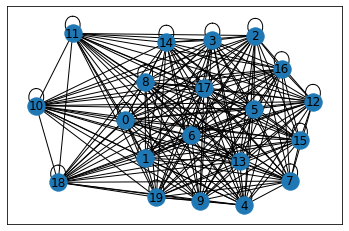

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx
from torch_sparse import SparseTensor
import math
def sigmoid(x):
    return 1 / (1 + math.e ** -x)

labels = data.y

model.eval()
z = model.encode(x,train_pos_edge_index)
adj_z=model.decode(z,train_pos_edge_index)

adj=torch.matmul(z,z.T)
A=torch.sigmoid(adj) if sigmoid else adj

z_s=z[:20]
adj_s = torch.matmul(z_s, z_s.t())
mat=torch.sigmoid(adj_s) if sigmoid else adj_s

H=nx.from_numpy_matrix(mat.cpu().detach().numpy())
nx.draw_networkx(H)


In [ ]:
z = model.encode(x,edge_index)

adj=torch.matmul(z,z.T)
A=torch.sigmoid(adj) if sigmoid else adj

print('latent vector size:',z.shape)
print('reconstructed adjacent matrix size::',A.shape)

"""value=(z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
j=(torch.sigmoid(value) if sigmoid else value).view([1,30])

G=nx.from_numpy_matrix(A.cpu().detach().numpy())
nx.draw_networkx(G)"""

latent vector size: torch.Size([20000, 1])
reconstructed adjacent matrix size:: torch.Size([20000, 20000])


'value=(z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)\nj=(torch.sigmoid(value) if sigmoid else value).view([1,30])\n\nG=nx.from_numpy_matrix(A.cpu().detach().numpy())\nnx.draw_networkx(G)'

In [ ]:
A.shape

torch.Size([20000, 20000])

# VGAE

In [ ]:
out_channels = 1
num_features = 11
epochs = 512
model = VGAE(VariationalGCNEncoder(num_features, out_channels))  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

data= drop_9.data
x = data.x.to(device)

#train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))  


Epoch: 001, AUC: 0.5202, AP: 0.5858
Epoch: 002, AUC: 0.5202, AP: 0.5858
Epoch: 003, AUC: 0.5202, AP: 0.5858
Epoch: 004, AUC: 0.5202, AP: 0.5858
Epoch: 005, AUC: 0.5303, AP: 0.5893
Epoch: 006, AUC: 0.5303, AP: 0.5893
Epoch: 007, AUC: 0.5303, AP: 0.5893
Epoch: 008, AUC: 0.5303, AP: 0.5893
Epoch: 009, AUC: 0.5202, AP: 0.5858
Epoch: 010, AUC: 0.5202, AP: 0.5858
Epoch: 011, AUC: 0.6694, AP: 0.6366
Epoch: 012, AUC: 0.6391, AP: 0.6180
Epoch: 013, AUC: 0.4050, AP: 0.4820
Epoch: 014, AUC: 0.4824, AP: 0.5105
Epoch: 015, AUC: 0.5191, AP: 0.5246
Epoch: 016, AUC: 0.5191, AP: 0.5246
Epoch: 017, AUC: 0.5191, AP: 0.5246
Epoch: 018, AUC: 0.5297, AP: 0.5298
Epoch: 019, AUC: 0.5188, AP: 0.5231
Epoch: 020, AUC: 0.4646, AP: 0.5032
Epoch: 021, AUC: 0.4518, AP: 0.4947
Epoch: 022, AUC: 0.5301, AP: 0.5309
Epoch: 023, AUC: 0.4971, AP: 0.5191
Epoch: 024, AUC: 0.4971, AP: 0.5191
Epoch: 025, AUC: 0.4873, AP: 0.5137
Epoch: 026, AUC: 0.4833, AP: 0.4986
Epoch: 027, AUC: 0.4833, AP: 0.4986
Epoch: 028, AUC: 0.4833, AP:

## Reconstruction of Adjacent Matrix from Latent Space Representation

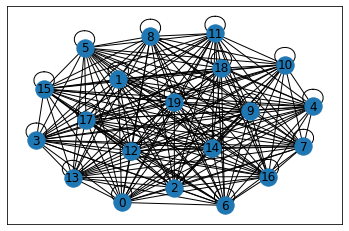

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
labels = data.y
#data.y = None
model.eval()
z = model.encode(x, train_pos_edge_index)

adj=torch.matmul(z,z.T)
A=torch.sigmoid(adj) if sigmoid else adj

z_s=z[:20]
adj_s = torch.matmul(z_s, z_s.t())
mat=torch.sigmoid(adj_s) if sigmoid else adj_s

H=nx.from_numpy_matrix(mat.cpu().detach().numpy())
nx.draw_networkx(H)


In [ ]:
z = model.encode(x,edge_index)

adj=torch.matmul(z,z.T)
A=torch.sigmoid(adj) if sigmoid else adj

print('latent vector size:',z.shape)
print('reconstructed adjacent matrix size::',A.shape)


latent vector size: torch.Size([20000, 1])
reconstructed adjacent matrix size:: torch.Size([20000, 20000])


In [ ]:
from torch_geometric.utils import to_dense_adj
to_dense_adj(edge_index).squeeze()


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])